In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv')

# print(data)
sleep_disorder_mapping = {label: idx for idx, label in enumerate(data['Sleep Disorder'].unique())}
data['Sleep Disorder'] = data['Sleep Disorder'].map(sleep_disorder_mapping)

# Save Sleep Disorder as a map
# Can be used after prediction
mapping_df = pd.DataFrame(list(sleep_disorder_mapping.items()), columns=['Class Name', 'Index'])
mapping_df.to_csv('sleep_disorder_mapping.csv', index=False)


# print(data['Sleep Disorder'].head(10))
print("Mapping of Sleep Disorder cxlasses to numbers:", sleep_disorder_mapping)
#print(data['Sleep Disorder'])

Mapping of Sleep Disorder cxlasses to numbers: {nan: 0, 'Sleep Apnea': 1, 'Insomnia': 2}


In [8]:
# Split x, y data
y_data = data[['Sleep Disorder']]
print(y_data)
x_data = data.drop(columns=['Sleep Disorder'])

# Correct x_data
x_data['BMI Category'] = x_data['BMI Category'].replace('Normal Weight', 'Normal')

#print(x_data)

     Sleep Disorder
0                 0
1                 0
2                 0
3                 1
4                 1
..              ...
369               1
370               1
371               1
372               1
373               1

[374 rows x 1 columns]


In [9]:
columns_to_drop = [
    'Person ID'
]
x_data = x_data.drop(columns=columns_to_drop)

In [10]:
# Split the 'Blood Pressure (systolic/diastolic)' column into two new columns
x_data[['Blood Pressure systolic', 'Blood Pressure diastolic']] = x_data['Blood Pressure'].str.split('/', expand=True)

x_data['Blood Pressure systolic'] = pd.to_numeric(x_data['Blood Pressure systolic'])
x_data['Blood Pressure diastolic'] = pd.to_numeric(x_data['Blood Pressure diastolic'])

x_data = x_data.drop(columns=['Blood Pressure'])

print("First few rows of x_data after splitting 'Blood Pressure':")
print(x_data.head())


First few rows of x_data after splitting 'Blood Pressure':
  Gender  Age            Occupation  Sleep Duration  Quality of Sleep  \
0   Male   27     Software Engineer             6.1                 6   
1   Male   28                Doctor             6.2                 6   
2   Male   28                Doctor             6.2                 6   
3   Male   28  Sales Representative             5.9                 4   
4   Male   28  Sales Representative             5.9                 4   

   Physical Activity Level  Stress Level BMI Category  Heart Rate  \
0                       42             6   Overweight          77   
1                       60             8       Normal          75   
2                       60             8       Normal          75   
3                       30             8        Obese          85   
4                       30             8        Obese          85   

   Daily Steps  Blood Pressure systolic  Blood Pressure diastolic  
0         4200     

In [11]:
# Split training and testing data

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


# One-hot encode categorical features in X_train and X_val

X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)


X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
# print("First few rows of X_train after one-hot encoding:")
# print(X_train.head())
# print("\nFirst few rows of X_val after one-hot encoding:")
# print(X_val.head())

In [12]:
# Do Scaling

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

# Display the first few rows to confirm scaling
# print("First few rows of X_train after scaling:")
# print(X_train.head())
# print("\nFirst few rows of X_val after scaling:")
# print(X_val.head())

In [13]:
# Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after resampling:")
print(y_train_resampled.value_counts())

Class distribution after resampling:
Sleep Disorder
0                 176
1                 176
2                 176
Name: count, dtype: int64


In [14]:
print(X_train)
print(X_val)

          Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
192  0.055811       -0.833457         -1.155098                -0.728644   
75  -1.111141       -1.468533         -1.155098                -1.450369   
84  -0.877751        0.436694          0.537913                -0.006920   
362  1.922934        1.325801          1.384419                 0.714805   
16  -1.577922       -0.833457         -2.001604                -0.969219   
..        ...             ...               ...                      ...   
71  -1.111141       -1.341518         -1.155098                -1.450369   
106 -0.644360       -1.341518         -1.155098                -0.872989   
270  0.755982       -1.341518         -1.155098                 1.436530   
348  1.689543        1.325801          1.384419                 0.714805   
102 -0.761056        0.055649          0.537913                -0.006920   

     Stress Level  Heart Rate  Daily Steps  Blood Pressure systolic  \
192      0.95660

### -------------------------------------------------------------------- Train With Decision Tree --------------------------------------------------------------------

In [20]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_split=10,  # 增加分裂節點的樣本數
    min_samples_leaf=5,    # 增加葉節點的樣本數
    random_state=42
)

In [23]:
# Train the model
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [24]:
# Predict on validation set
y_pred = clf.predict(X_val)

In [18]:
# Convert sleep_disorder_mapping keys to a sorted list of strings
target_names = [str(k) for k in sorted(sleep_disorder_mapping.keys(), key=lambda x: sleep_disorder_mapping[x])]

# Evaluate the model
# print("Classification Report:")
# print(classification_report(y_val, y_pred, target_names=target_names))

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')  # weighted handles class imbalance
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Display metrics
print(f"Accuracy Score: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Accuracy Score: 90.67%
Precision: 90.55%
Recall: 90.67%
F1 Score: 90.58%


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = clf.predict_proba(X_val)
auroc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr')
print(f"AUROC: {auroc*100:.2f}%")

AUROC: 89.11%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


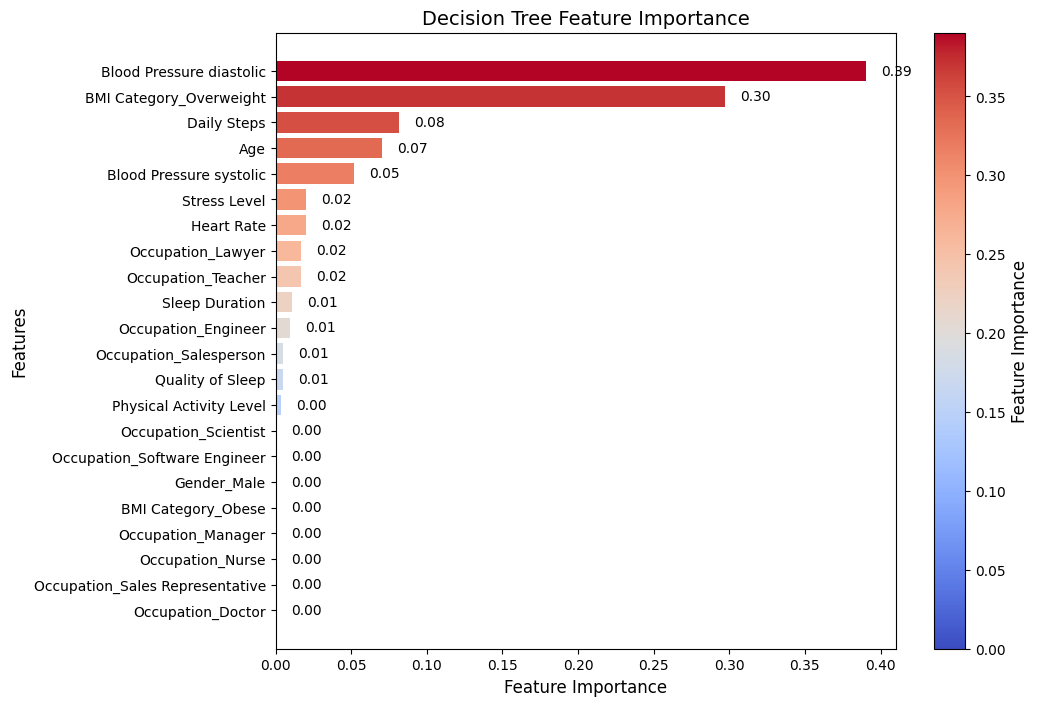

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 特徵重要性與排序
feature_importances = clf.feature_importances_
sorted_idx = feature_importances.argsort()

# 條狀圖顏色 (根據特徵重要性分佈)
bar_colors = plt.cm.coolwarm(np.linspace(0, 1, len(feature_importances)))

# 創建子圖，明確指定 colorbar 關聯的 Axes
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(
    X_train.columns[sorted_idx],
    feature_importances[sorted_idx],
    color=bar_colors
)

# 在每條條狀圖上顯示數值
for bar, importance in zip(bars, feature_importances[sorted_idx]):
    ax.text(
        bar.get_width() + 0.01,  # 位於條狀圖的右側
        bar.get_y() + bar.get_height() / 2,  # 水平居中
        f'{importance:.2f}',  # 顯示數值（保留兩位小數）
        va='center',  # 垂直居中
        fontsize=10  # 字體大小
    )

# 添加 Colorbar 作為 Legend
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=feature_importances.min(), vmax=feature_importances.max()))
sm.set_array([])  # 必須設置 array，否則 colorbar 無法生成
cbar = fig.colorbar(sm, ax=ax)  # 明確將 colorbar 關聯到當前的子圖
cbar.set_label('Feature Importance', fontsize=12)

# 添加標籤和標題
ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
ax.set_title("Decision Tree Feature Importance", fontsize=14)

plt.show()

# Apriori

In [ ]:
!pip install --upgrade mlxtend

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from mlxtend.frequent_patterns import apriori
from itertools import combinations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Apriori Algorithm
# print(y_data)
y_data['Has_Sleep_Disorder'] = y_data['Sleep Disorder'] > 0  # 0 -> None; 1 -> Sleep Apnea or Insomnia

# One-hot encoding to the data
X_onehot = pd.get_dummies(x_data)

# Ensure that the numeric data were be divided to binary feature
for col in X_onehot.select_dtypes(include=['float64', 'int64']).columns:
    X_onehot[col] = X_onehot[col] > X_onehot[col].median()  # Use the median to be threshold

X_onehot['Has_Sleep_Disorder'] = y_data['Has_Sleep_Disorder']

# Apply Apriori algorithm
frequent_itemsets = apriori(X_onehot, min_support=0.1, use_colnames=True)

# Compute the association rules
rules = []
for _, row in frequent_itemsets.iterrows():
    items = list(row['itemsets'])
    for i in range(1, len(items)):
        for antecedent in combinations(items, i):
            antecedent = frozenset(antecedent)
            consequent = frozenset(items) - antecedent
            antecedent_support = frequent_itemsets[frequent_itemsets['itemsets'] == antecedent]['support'].values[0]
            consequent_support = frequent_itemsets[frequent_itemsets['itemsets'] == consequent]['support'].values[0]
            confidence = row['support'] / antecedent_support
            lift = confidence / consequent_support
            rules.append({
                'antecedents': antecedent,
                'consequents': consequent,
                'support': row['support'],
                'confidence': confidence,
                'lift': lift
            })


rules_df = pd.DataFrame(rules)

# Filter the consequent to be exactly "Has_Sleep_Disorder"
target_rules = rules_df[rules_df['consequents'] == frozenset({'Has_Sleep_Disorder'})]

# Remove redundant rules
def remove_redundant_rules(rules_df):
    non_redundant_rules = []
    for idx, rule in rules_df.iterrows():
        is_redundant = False
        for other_idx, other_rule in rules_df.iterrows():
            if idx != other_idx and rule['antecedents'].issubset(other_rule['antecedents']):
                if other_rule['confidence'] >= rule['confidence'] and other_rule['lift'] >= rule['lift']:
                    is_redundant = True
                    break
        if not is_redundant:
            non_redundant_rules.append(rule)
    return pd.DataFrame(non_redundant_rules)

filtered_rules = remove_redundant_rules(target_rules)

count = 0
print("Filtered Rules involving Has_Sleep_Disorder:")
for idx, rule in filtered_rules.iterrows():
  if rule['support'] >= 0.1 and rule['confidence'] >= 0.7 and rule['lift'] >= 1.5:
    count += 1
    print(f"Rule #{count}:")
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']:.2f}")
    print(f"Confidence: {rule['confidence']:.2f}")
    print(f"Lift: {rule['lift']:.2f}")
    print("---------------------------")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-70-0429e4092230>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data['Has_Sleep_Disorder'] = y_data['Sleep Disorder'] > 0  # 0 -> None; 1 -> Sleep Apnea or Insomnia


Filtered Rules involving Has_Sleep_Disorder:
Rule #1:
Antecedents: {'Stress Level', 'Blood Pressure diastolic'}
Consequents: {'Has_Sleep_Disorder'}
Support: 0.11
Confidence: 0.96
Lift: 2.31
---------------------------
Rule #2:
Antecedents: {'Blood Pressure diastolic', 'Heart Rate'}
Consequents: {'Has_Sleep_Disorder'}
Support: 0.13
Confidence: 0.96
Lift: 2.32
---------------------------
Rule #3:
Antecedents: {'Stress Level', 'Blood Pressure diastolic', 'Heart Rate'}
Consequents: {'Has_Sleep_Disorder'}
Support: 0.11
Confidence: 0.95
Lift: 2.30
---------------------------
Rule #4:
Antecedents: {'Stress Level', 'Blood Pressure diastolic', 'Blood Pressure systolic'}
Consequents: {'Has_Sleep_Disorder'}
Support: 0.11
Confidence: 0.95
Lift: 2.30
---------------------------
Rule #5:
Antecedents: {'Stress Level', 'Blood Pressure diastolic', 'Gender_Female'}
Consequents: {'Has_Sleep_Disorder'}
Support: 0.10
Confidence: 0.95
Lift: 2.29
---------------------------
Rule #6:
Antecedents: {'Blood Pres